## Using Histigram Oriented Feature for Segmentation

In [1]:
#Import the required modules

import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import imageio
from skimage import exposure
from skimage import feature
import cv2

In [2]:
#Function to extract patches of specified size with specified stride
def extract_patches(arr,patch_shape,stride):
    new_shape = ( (arr.shape[0]-patch_shape) //stride )+1
    x_part=[None]*(new_shape*new_shape)
    for j in range(new_shape):
        for k in range(new_shape):
            img_x=arr[stride*j:stride*j+patch_shape,stride*k:stride*k+patch_shape]
            img_x=feature.hog(img_x,orientations=9,pixels_per_cell=(3,3),cells_per_block=(1,1),transform_sqrt=True)
            x_part[j*new_shape + k] = img_x;
    return np.vstack(x_part)

In [3]:
#Function which takes list if image names and returns corresponding one dimensional vector for
#each of the images
def return_dataset(listlabels,dset):
    new_shape=((256-15)//1)+1
    
    full_feature=[None]*len(listlabels)
    full_target=[None]*len(listlabels)
    
    for n,i in enumerate(listlabels):
        if dset==0:
            image=loadmat('/beegfs/ark576/Knee Cartilage Data/Train Data/{}'.format(i))
        elif dset==1:
            image=loadmat('/beegfs/ark576/Knee Cartilage Data/Validation Data/{}'.format(i))
        else:
            image=loadmat('/beegfs/ark576/Knee Cartilage Data/Test Data/{}'.format(i))

        feature_list=[None] * 15
        target_list=[None]*15
        min_val=np.min(image['MDnr'])
        #print(min_val)
        print(n)
        for j in range(15):
            im=image['MDnr'][:,:,j]
            targets_all=image['SegmentationF'][:,:,j]+image['SegmentationT'][:,:,j]+image['SegmentationP'][:,:,j]
            tar=targets_all[7:-7,7:-7]
            target_m=tar.reshape(1,-1)
            #print(target_m.shape)
            features=extract_patches(im-min_val,15,1)
            feature_list[j]=features
            target_list[j]=target_m
            #print("target list:",len(target_list))
        full_feature[n]=np.vstack(feature_list)
        temp_tar=np.hstack(target_list)
        #print("temp tar shape:",temp_tar.shape)
        #full_target[n]=np.concatenate(target_list)
        full_target[n]=temp_tar
        #print(len(full_target))
    target_out=np.hstack(full_target)
    #print(target_out.shape)
    #print(full_target)
    return np.vstack(full_feature),target_out

In [4]:
import pickle
with open("/beegfs/ark576/Knee Cartilage Data/Train Data/train_file_names",'rb') as f:
    train_list=pickle.load(f)

In [5]:
import pickle
with open("/beegfs/ark576/Knee Cartilage Data/Validation Data/val_file_names",'rb') as f:
    val_list=pickle.load(f)

In [ ]:
#Function to undersample the negetive examples
def undersampling_fun(fr,tr,undersampling=0.01):
    #tr=np.reshape(tr,(-1,1))
    idx_1 = np.where(tr == 1)[1];
    idx_0 = np.where(tr == 0)[1];

    idx_0_selected = np.random.choice(idx_0, np.ceil(undersampling * len(idx_0)).astype('int') )

    fr = fr[np.hstack([idx_0_selected, idx_1])];
    tr = tr[:,np.hstack([idx_0_selected, idx_1])];
    
    return fr,tr

In [6]:
#Train set
feature_x,target_y=return_dataset(train_list,0)

0


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [7]:
#Validation set
feature_x_val,target_y_val = return_dataset(val_list,1)

0


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1
2
3
4
5
6


In [ ]:
#Undersampling the -ve examples
fr_1,tr_1=undersampling_fun(feature_x,target_y)
fr_2,tr_2=undersampling_fun(feature_x,target_y,0.03)

In [ ]:
#Fit a SVM classifier on train set
from sklearn.svm import SVC

svm_model = SVC(class_weight='balanced')
svm_model.fit(fr_1,np.reshape(tr_1,(-1,1)))

In [ ]:
#Predict for the validation set
val_pred = hog_svm_1.predict(feature_x_val)

In [1]:
#Compute the validation dice loss
from scipy.spatial.distance import dice

dice_loss=dice(target_y_val,val_pred)
print(dice_loss)

9.8


In [7]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'),protocol=4)   
    
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

## Visualizing what HOG for an image

In [13]:
from skimage import exposure
from skimage import feature
import cv2

one_image=train_list[1]
one_image_image=loadmat('/beegfs/ark576/Knee Cartilage Data/Train Data/{}'.format(one_image))
print("original image size: ",one_image_image['MDnr'].shape)
hog_image,HOG=feature.hog(one_image_image['MDnr'][:,:,2],orientations=9,pixels_per_cell=(15,15),cells_per_block=(4,4),visualise=True)
print("HOG image size: ",hog_image.shape)

original image size:  (256, 256, 15)
HOG image size:  (28224,)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


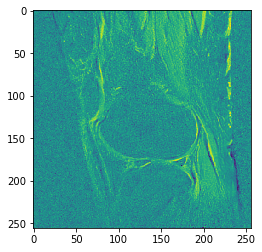

In [5]:
#Original image
plt.imshow(one_image_image['MDnr'][:,:,1])

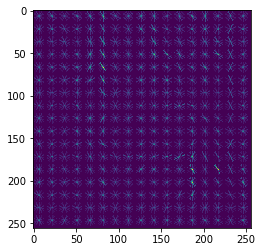

In [6]:
#Histogram Oriented Feature of the above image
plt.imshow(HOG)